# Typology for doubles

1. Identify 2-artifact clusters (pairs of contiguous artifacts); make sure that the union has no interior
2. For each cluster, classify the inside edge as C or nonC (`drop_interline`: bool)
3. Visualize and test if it works

- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
import logging

import folium
import folium.plugins as plugins
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from scipy import sparse, spatial
from sgeop.geometry import _is_within, snap_to_targets, voronoi_skeleton
from sgeop.nodes import consolidate_nodes

from core import algorithms, utils

In [2]:
import warnings

# Filter out the RuntimeWarning
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in intersection",
)

In [3]:
# Get the logger for core.algorithms.simplify
logger = logging.getLogger("core.algorithms.simplify")
logger.setLevel(logging.DEBUG)

# Set the logging format
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

# Create a handler for the logger
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

Specify case metadata

In [4]:
case = "Liège"

Read road data

In [5]:
roads = utils.read_original(case)

Remove duplicated roads

In [6]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Merge nearby nodes (up to double of distance used in skeleton).

In [7]:
roads = consolidate_nodes(roads, tolerance=4)

Identify artifacts

In [8]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [9]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Filter doubles

In [20]:
rook = graph.Graph.build_contiguity(artifacts, rook=True)
artifacts["comp"] = rook.component_labels
counts = artifacts["comp"].value_counts()
artifacts = artifacts.loc[artifacts["comp"].isin(counts[counts == 2].index)]

Optionally define a subset of data.

In [14]:
data_sample = artifacts.sort_values("comp").copy()
data_sample = data_sample.iloc[30].copy()

In [18]:
new_roads = algorithms.simplify.simplify_pairs(data_sample, roads)

1


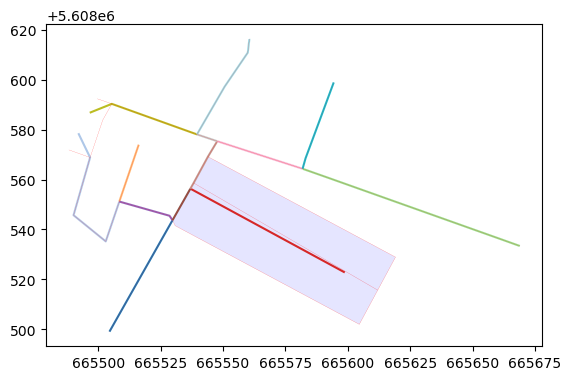

4


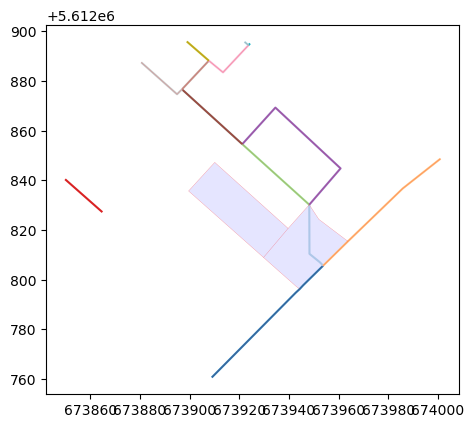

6


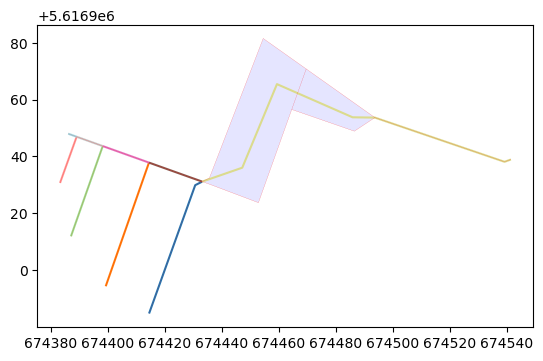

7


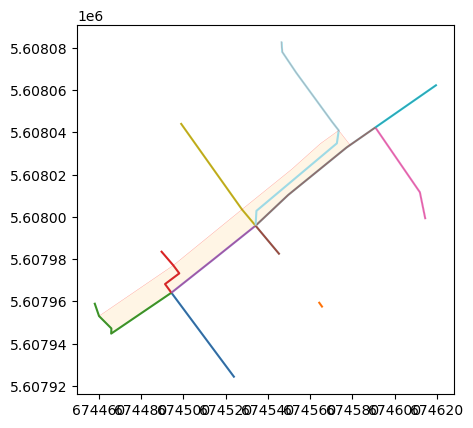

9


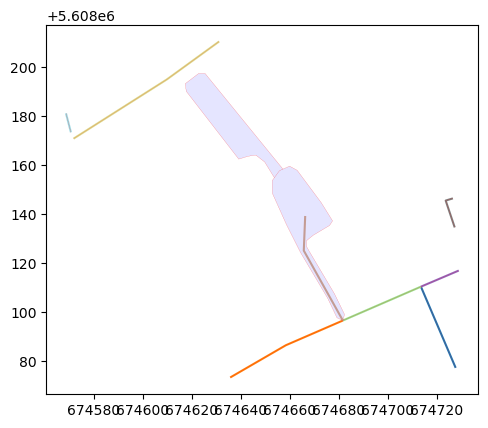

10


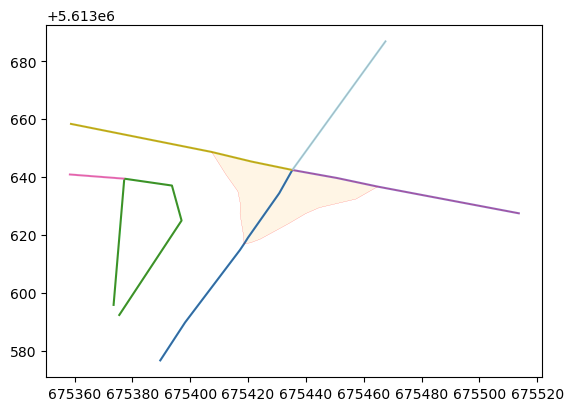

18


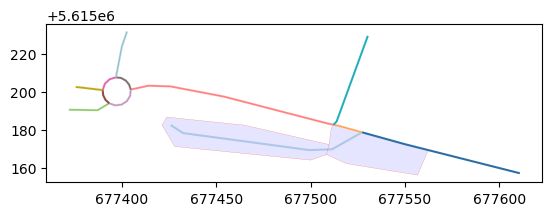

25


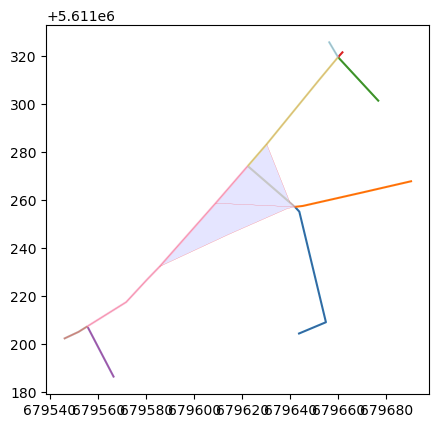

33


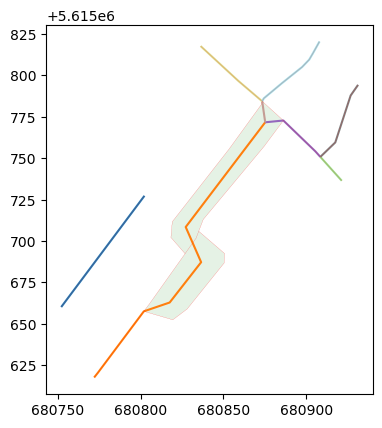

40


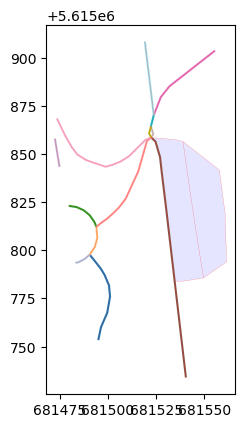

53


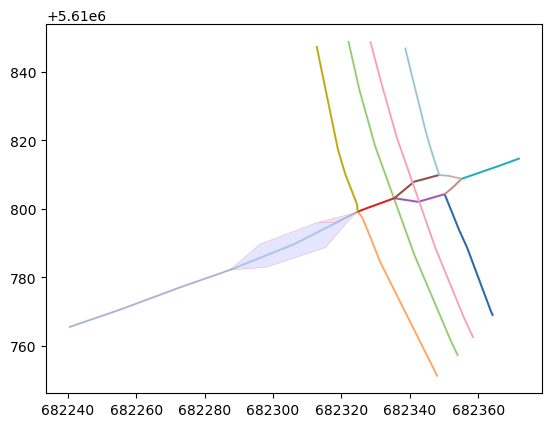

54


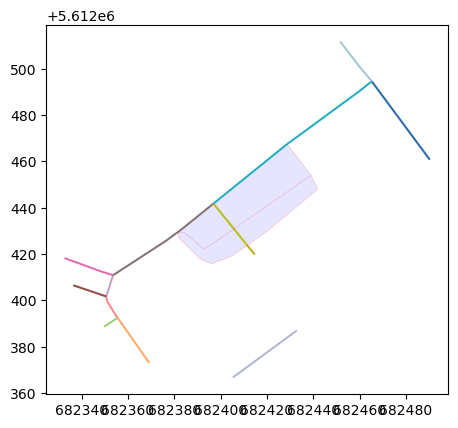

60


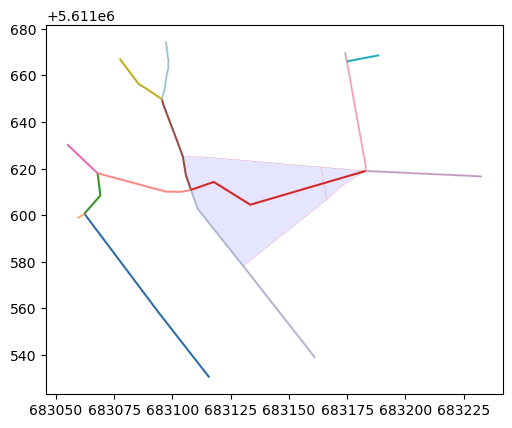

67


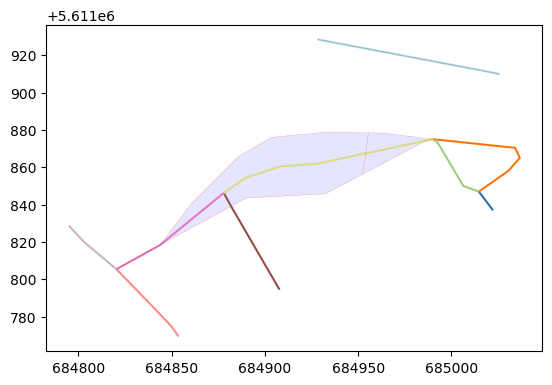

69


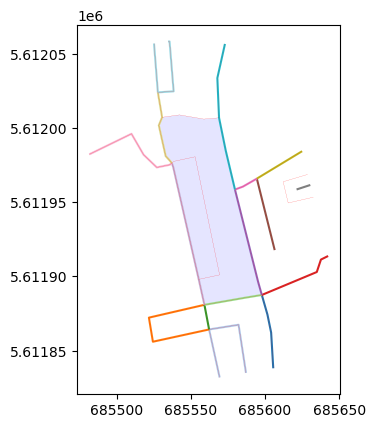

72


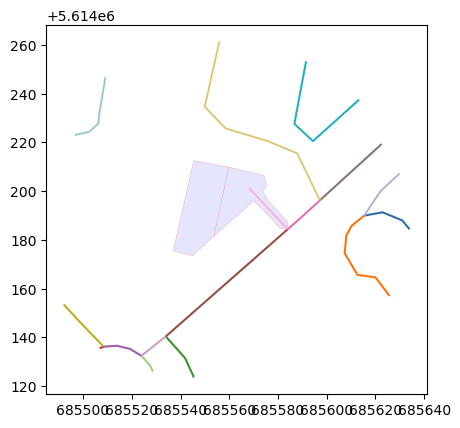

83


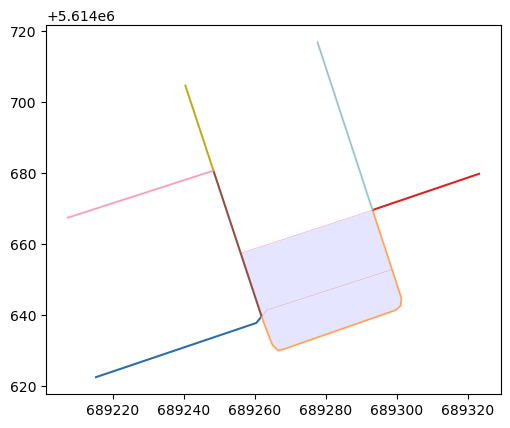

89


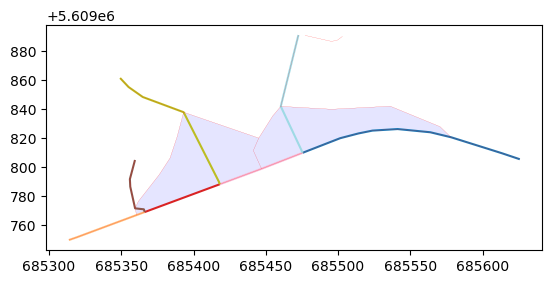

90


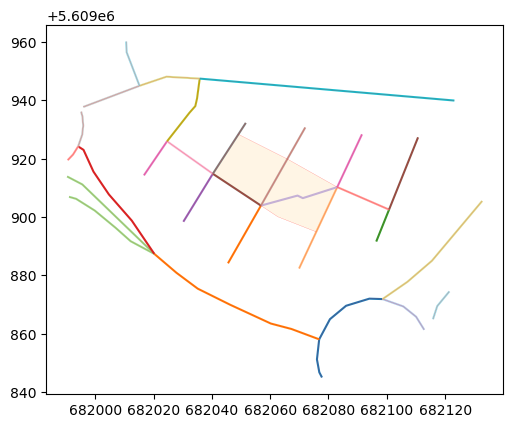

91


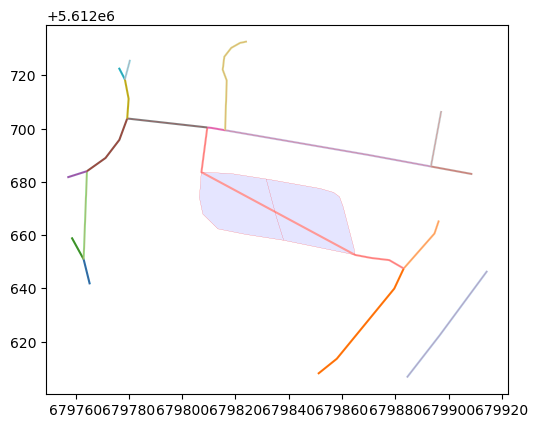

108


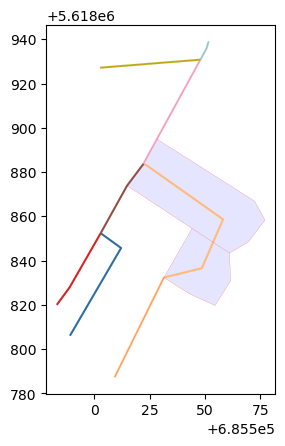

116


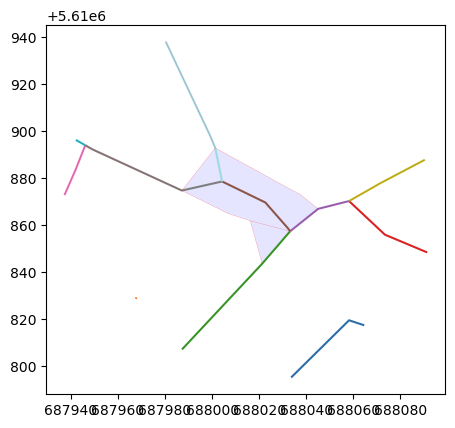

117


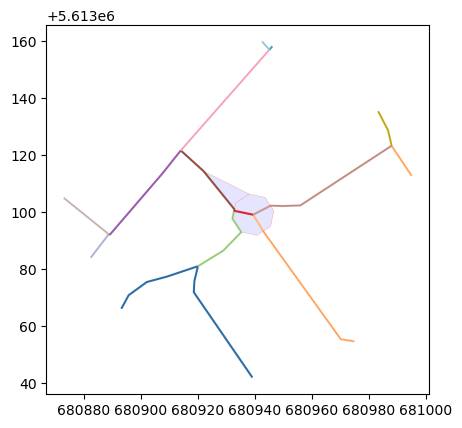

124


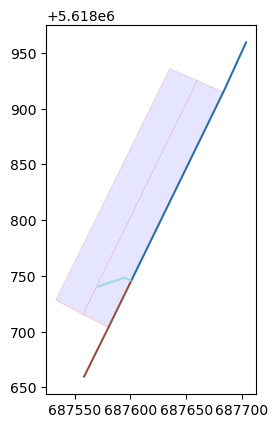

125


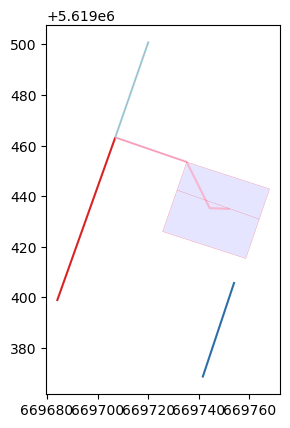

126


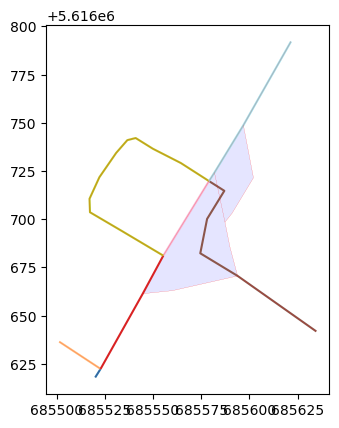

128


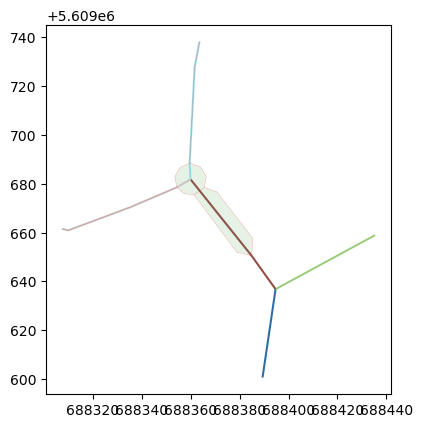

134


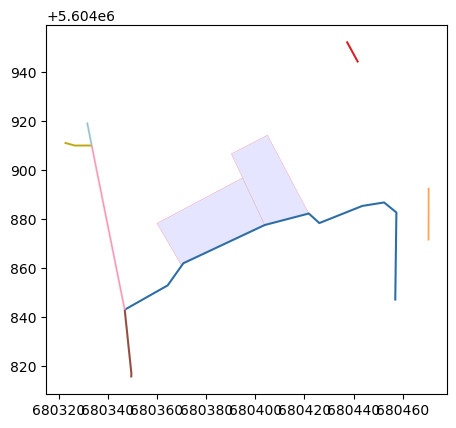

139


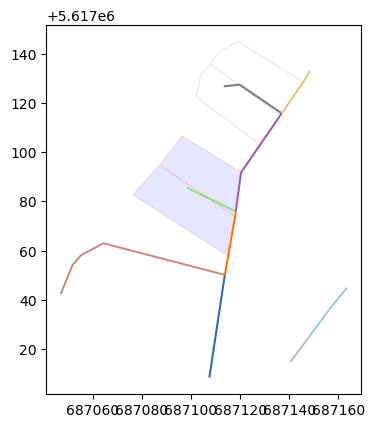

148


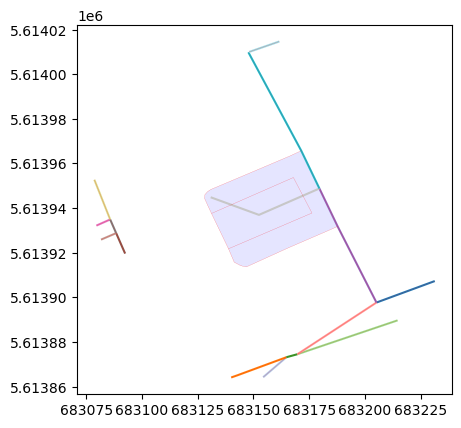

150


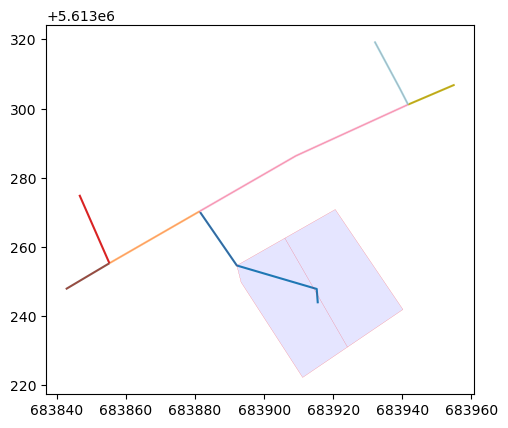

164


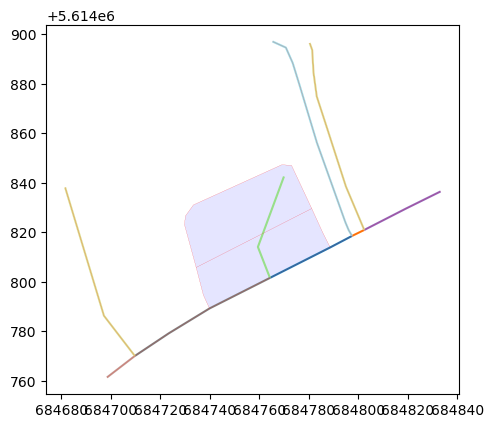

169


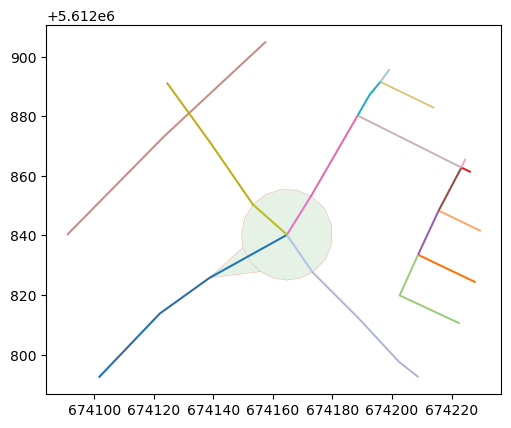

171


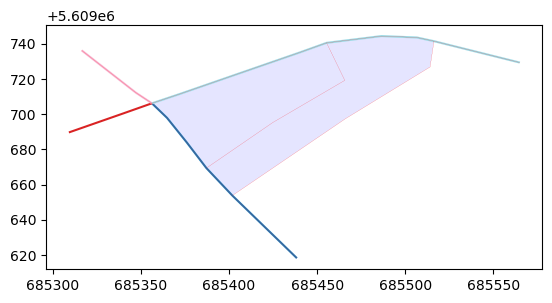

172


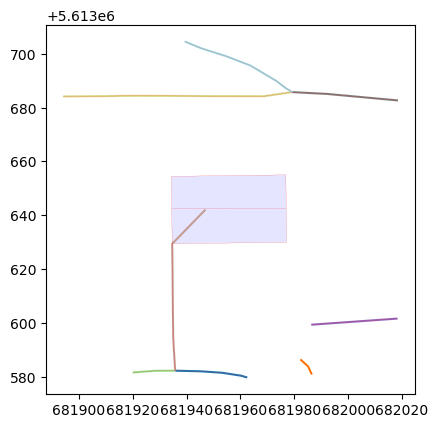

174


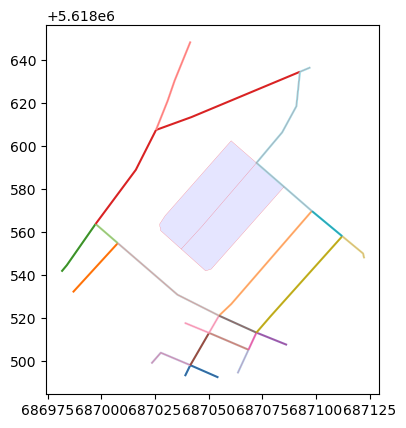

207


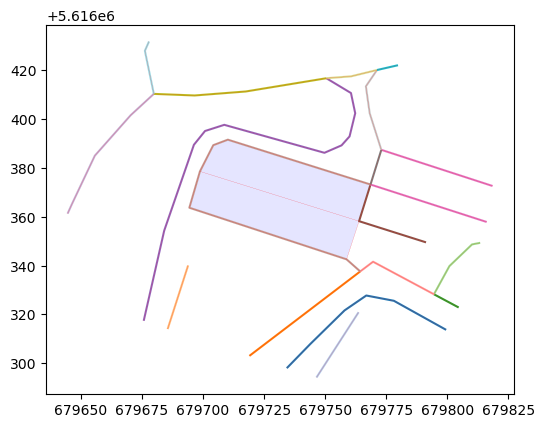

217


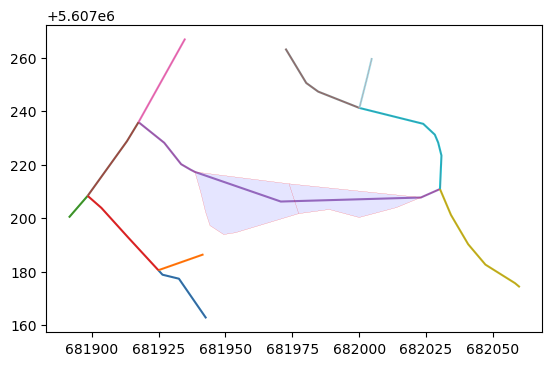

219


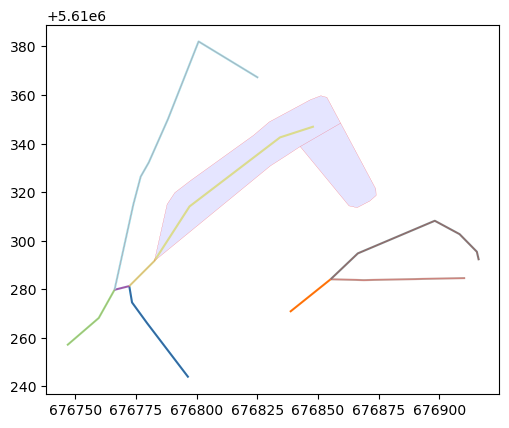

230


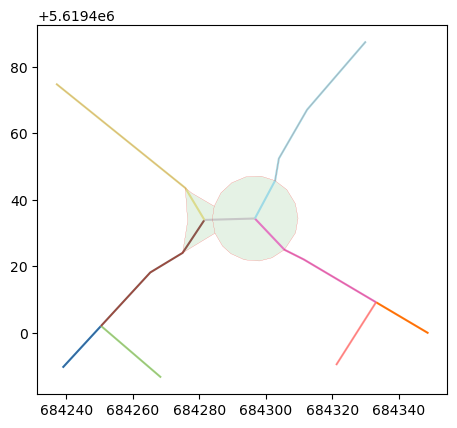

255


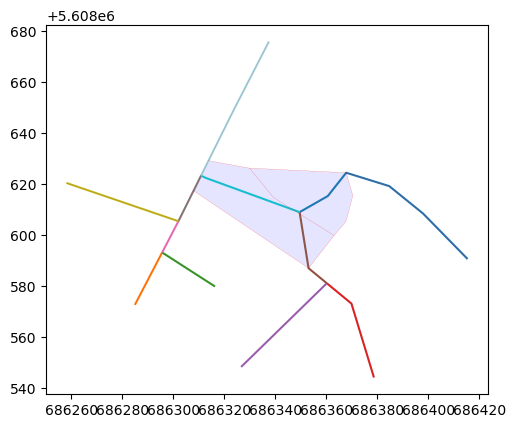

263


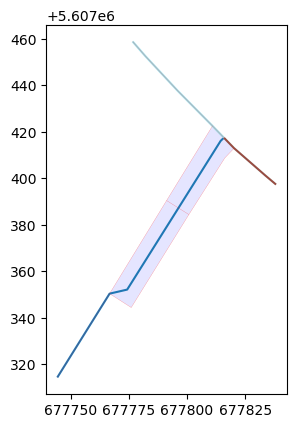

270


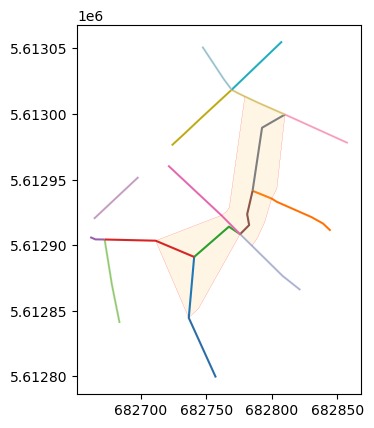

278


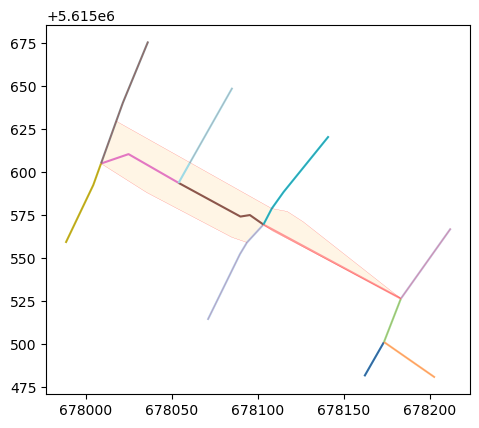

289


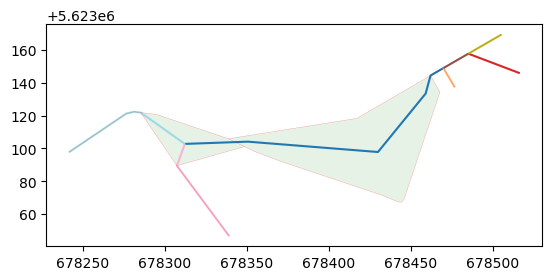

295


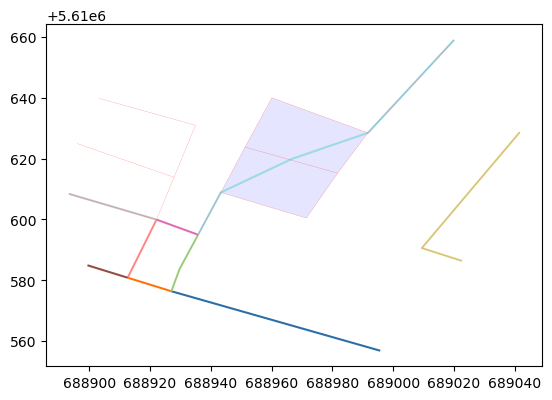

301


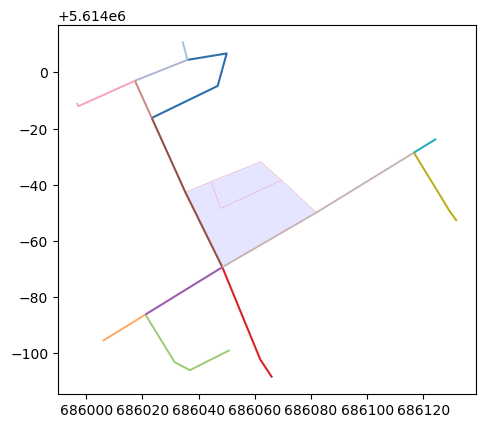

311


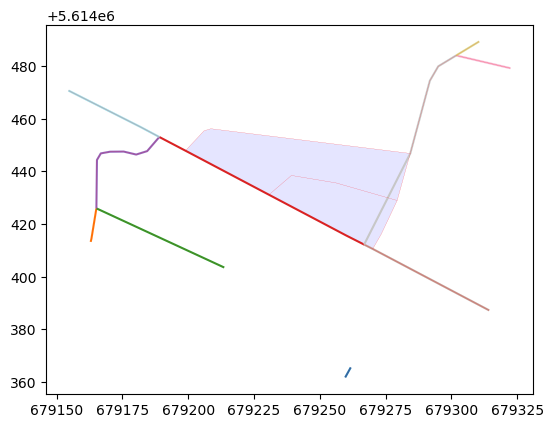

316


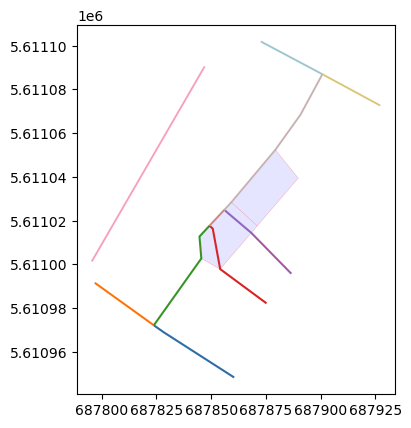

317


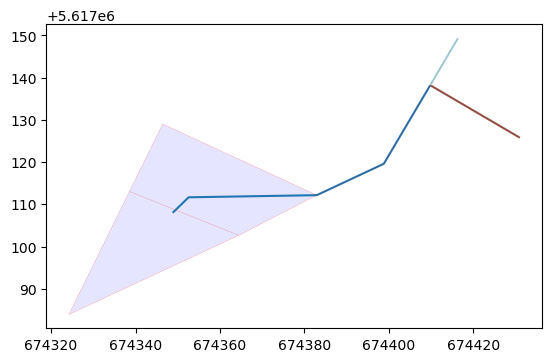

318


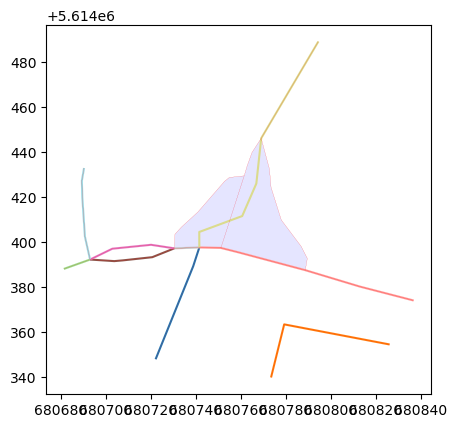

320


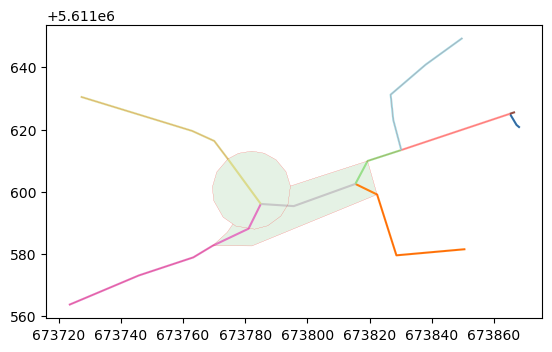

324


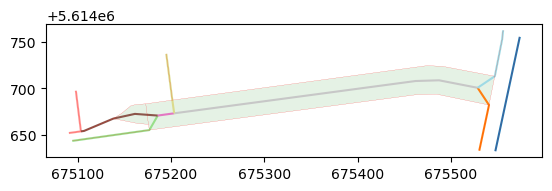

325


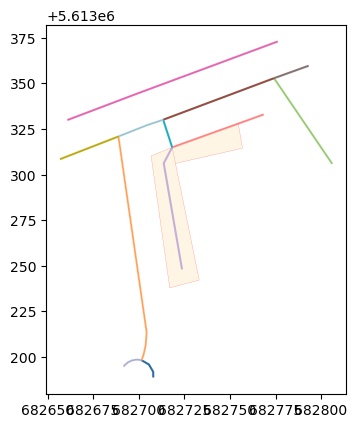

329


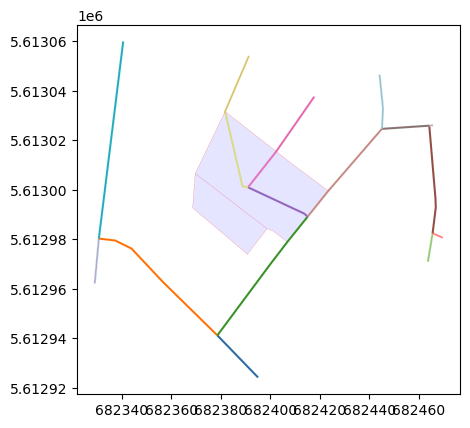

330


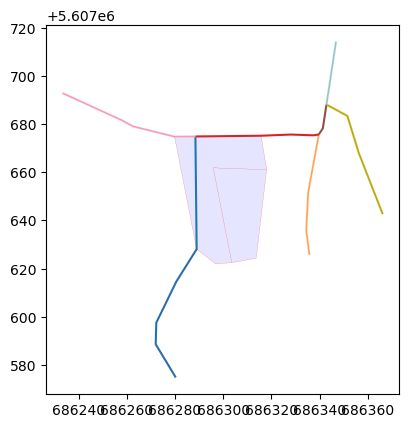

333


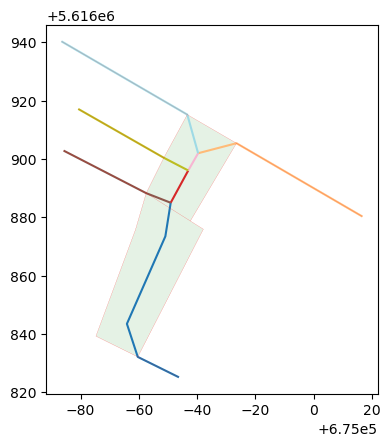

336


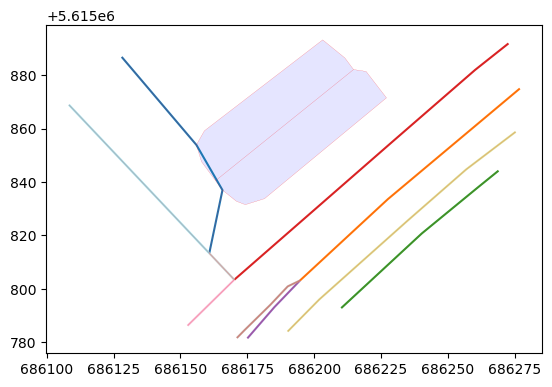

338


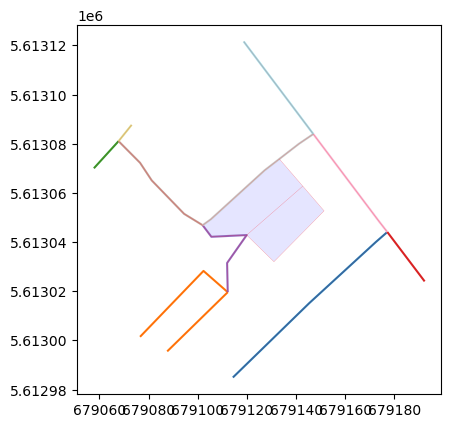

344


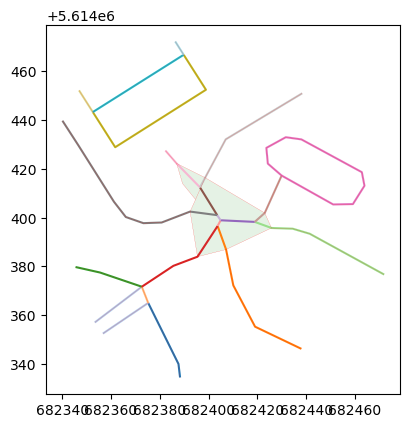

346


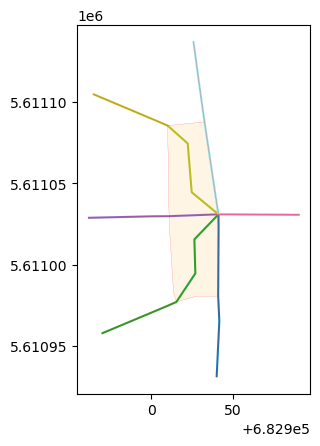

348


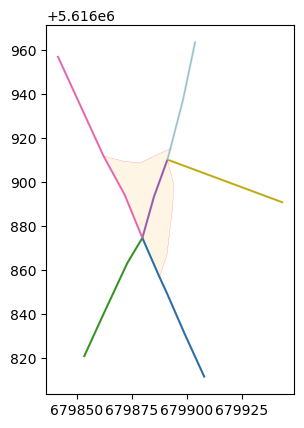

350


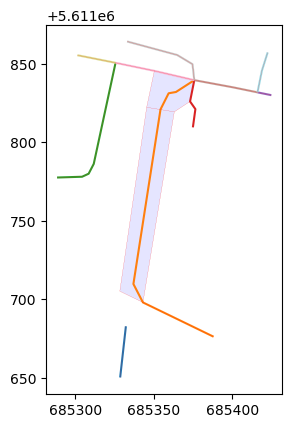

360


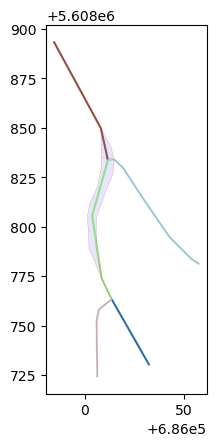

362


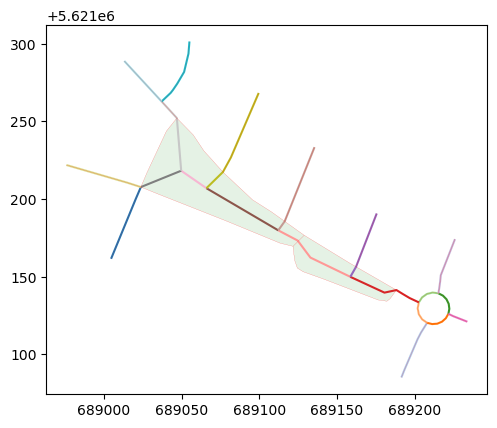

372


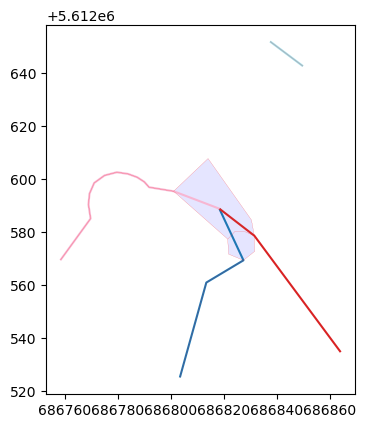

374


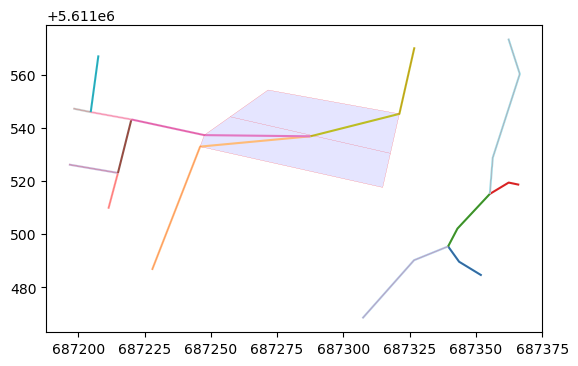

392


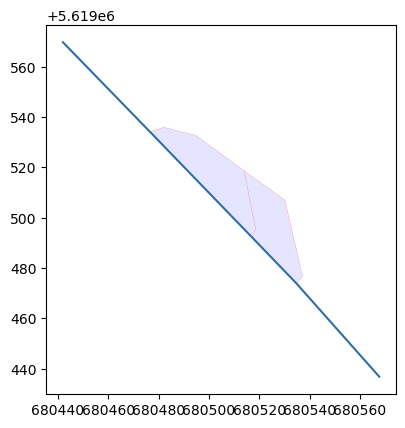

394


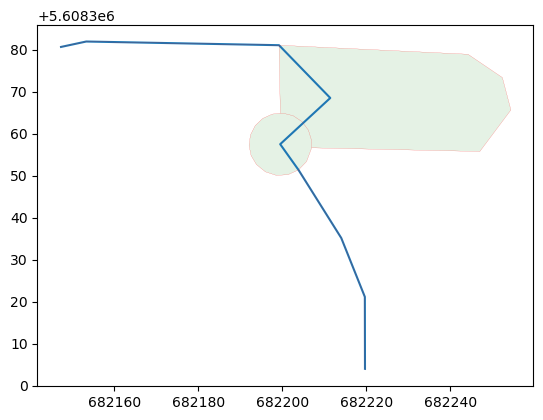

395


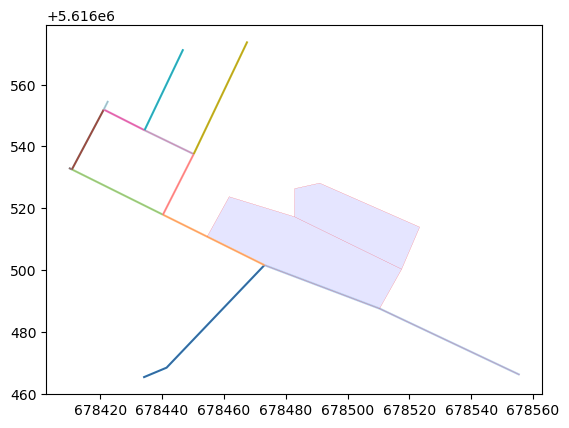

400


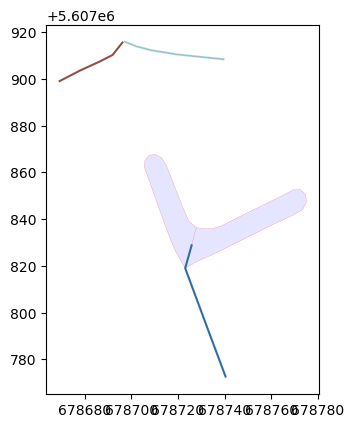

407


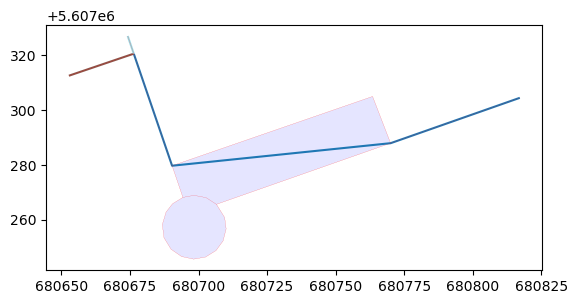

409


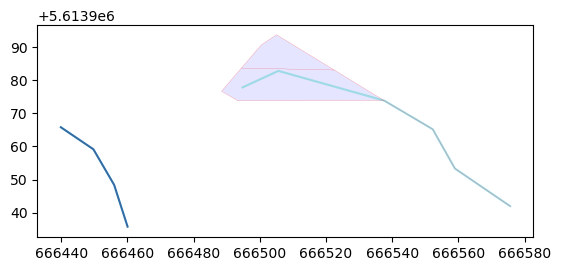

416


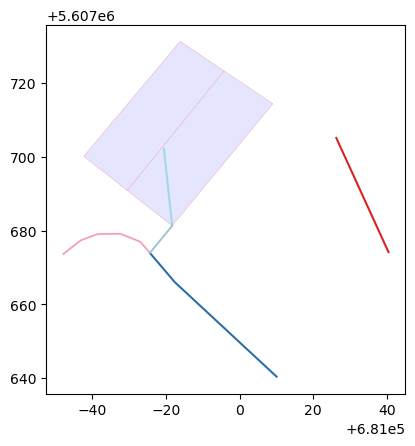

424


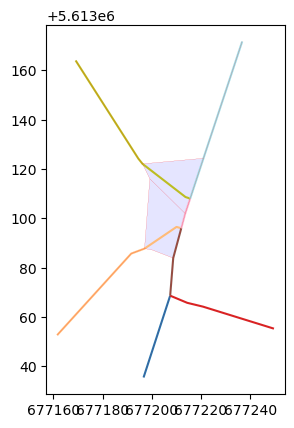

425


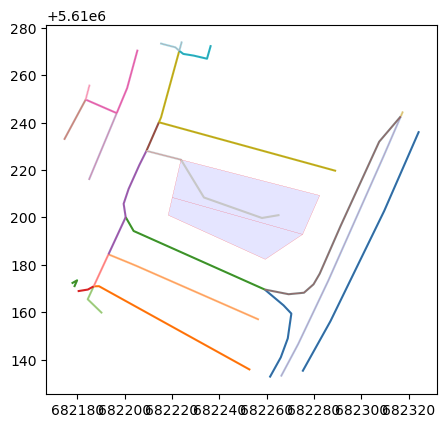

426


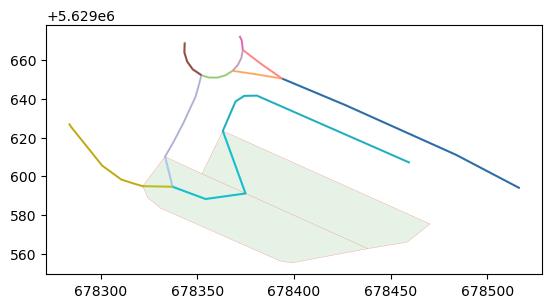

431


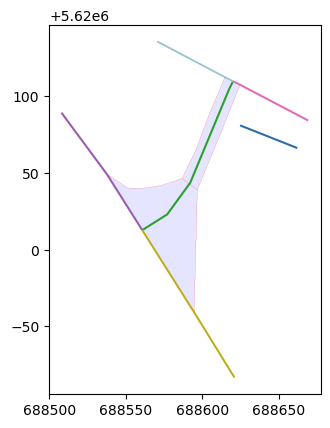

434


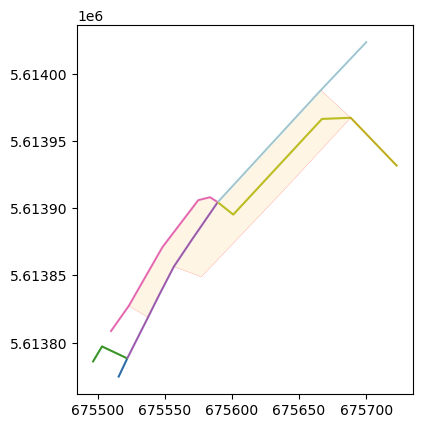

435


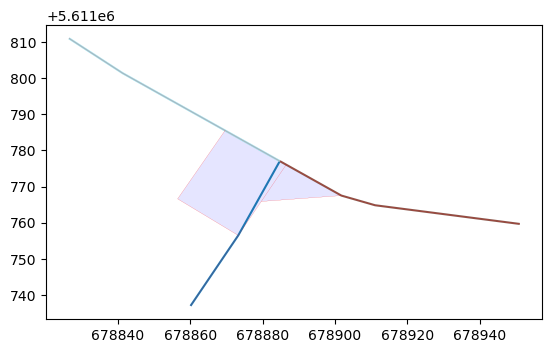

438


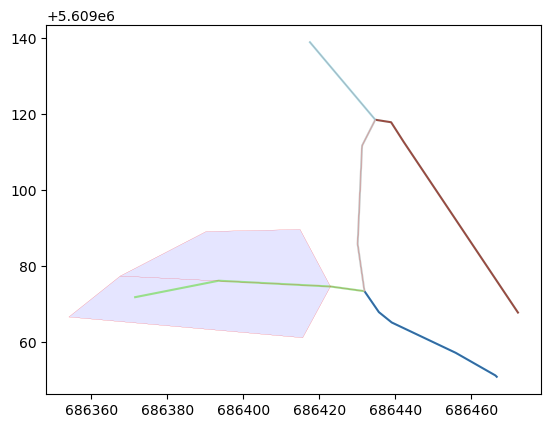

441


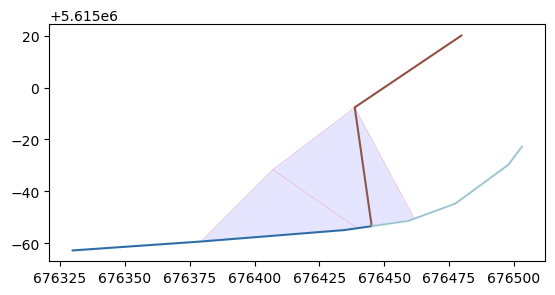

442


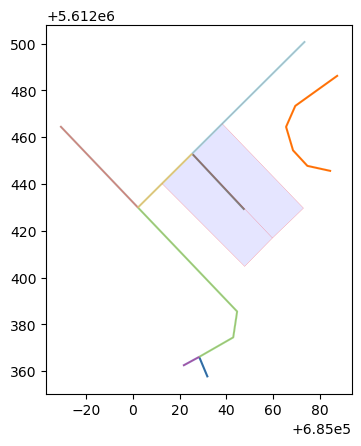

443


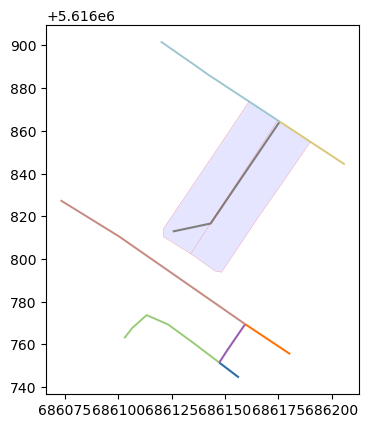

444


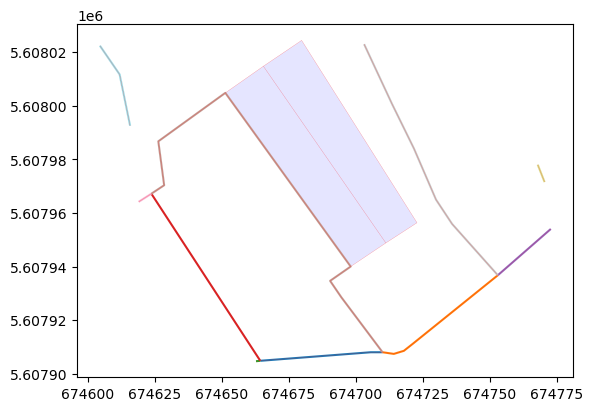

446


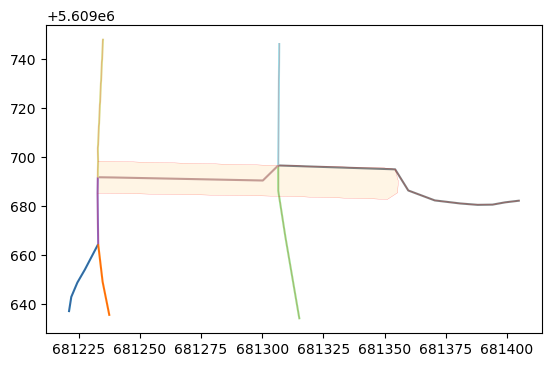

452


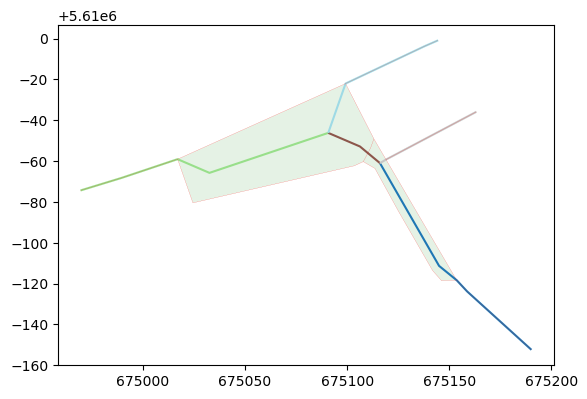

458


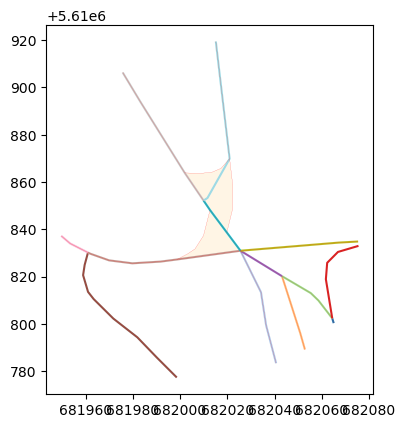

467


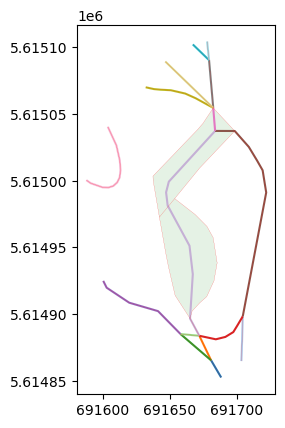

471


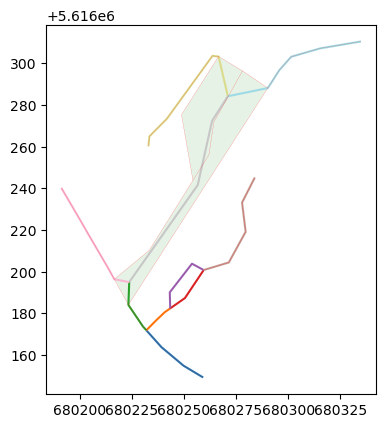

482


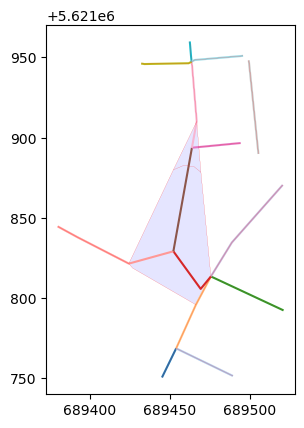

483


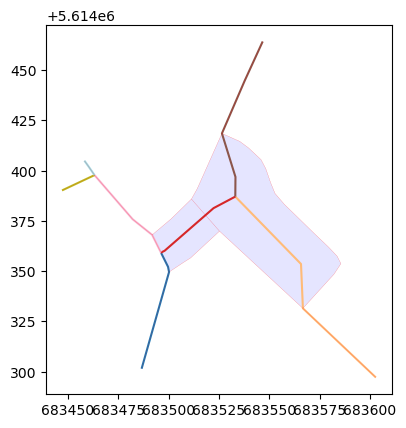

521


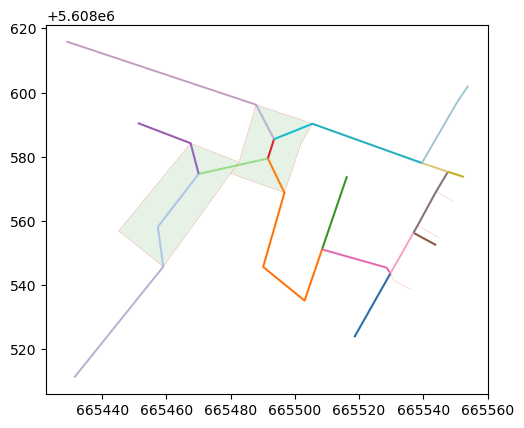

523


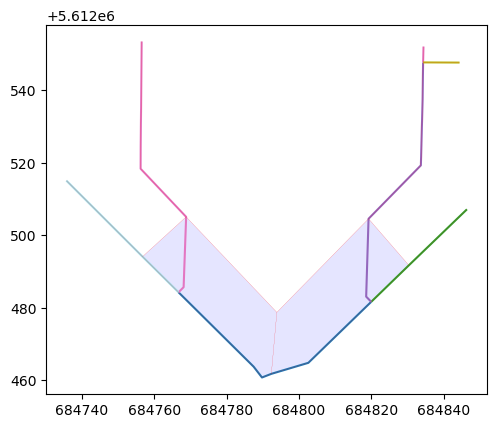

524


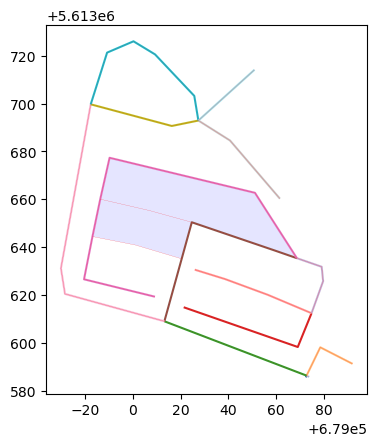

525


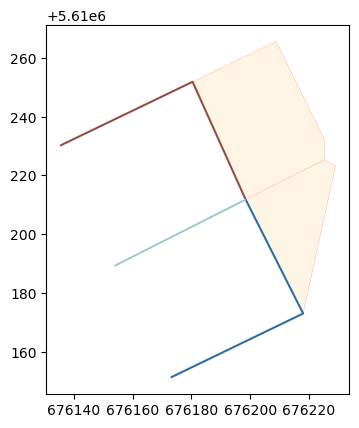

538


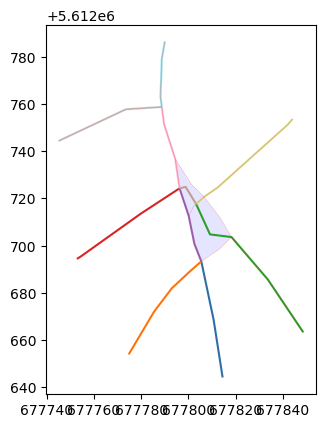

539


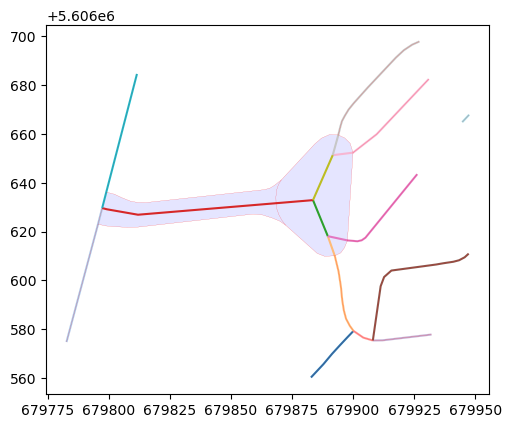

540


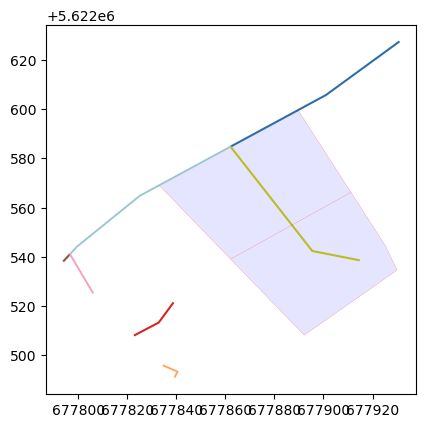

541


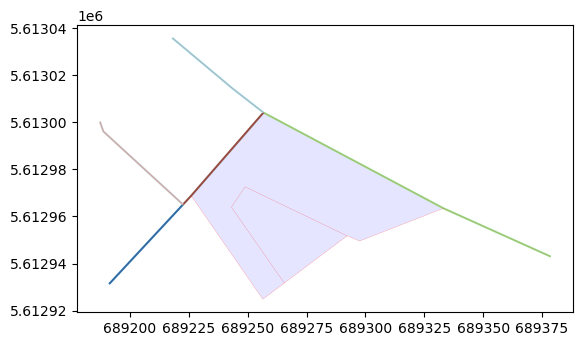

550


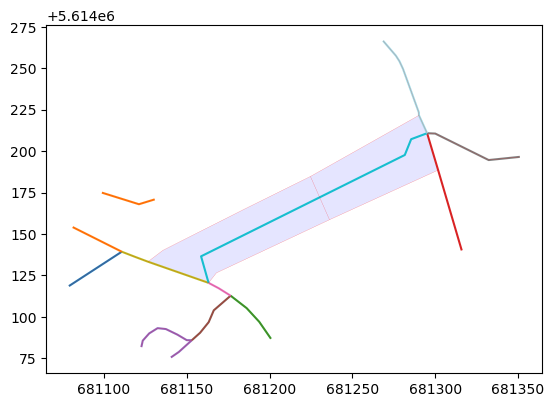

552


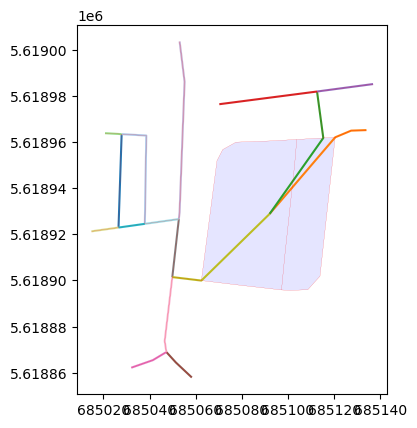

559


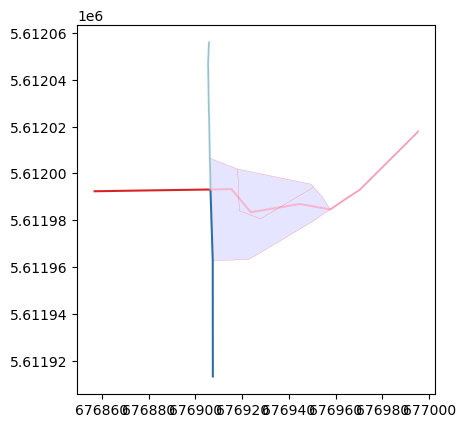

560


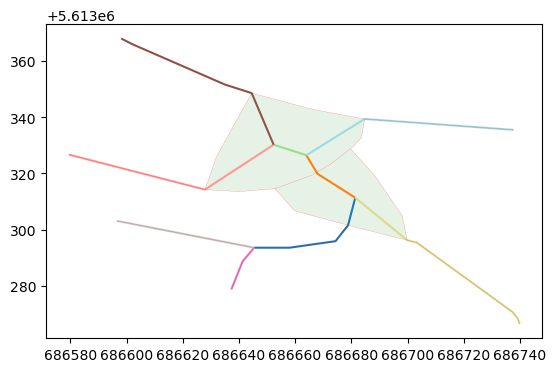

562


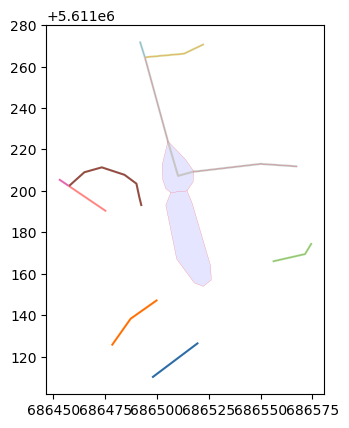

566


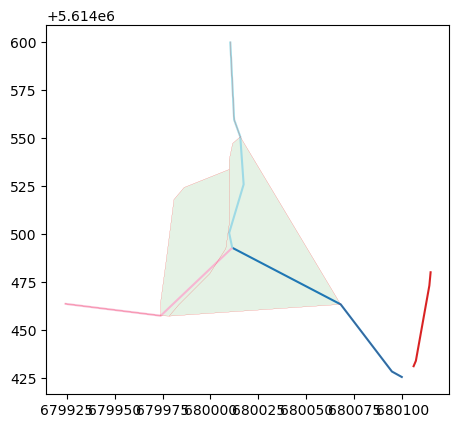

570


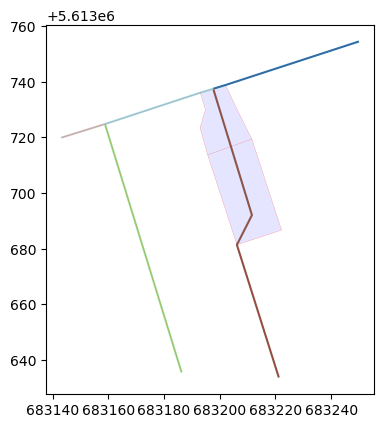

572


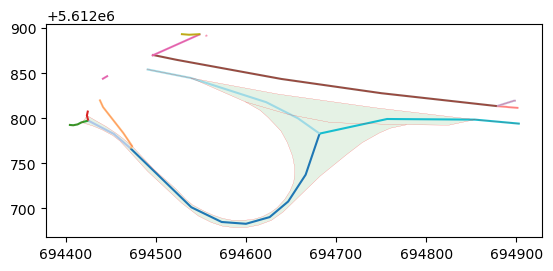

594


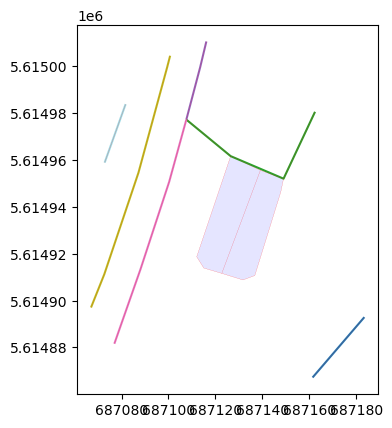

605


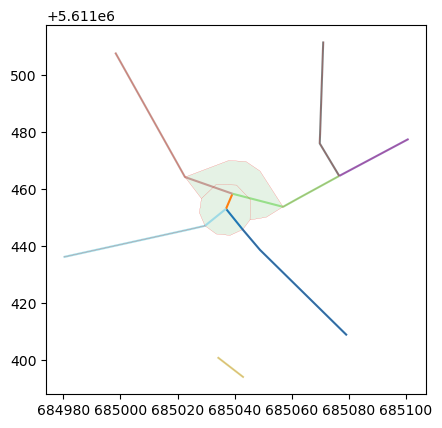

609


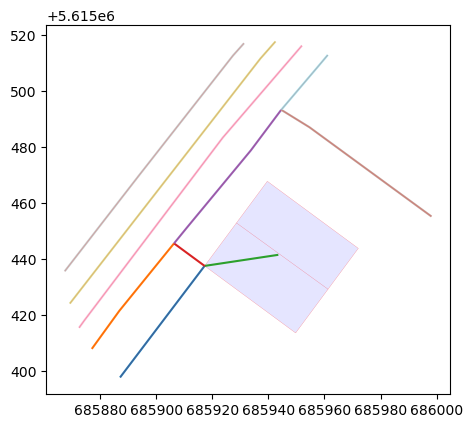

611


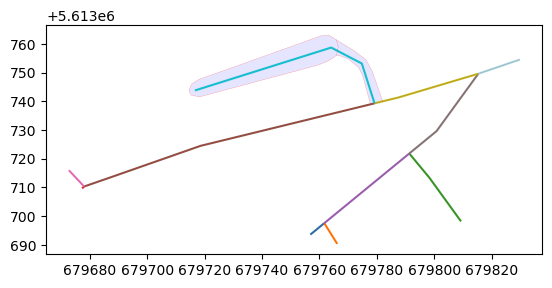

618


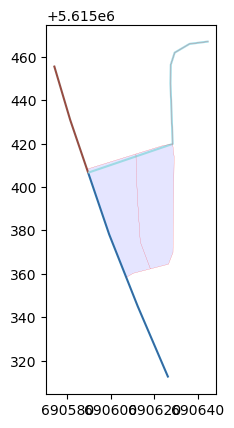

619


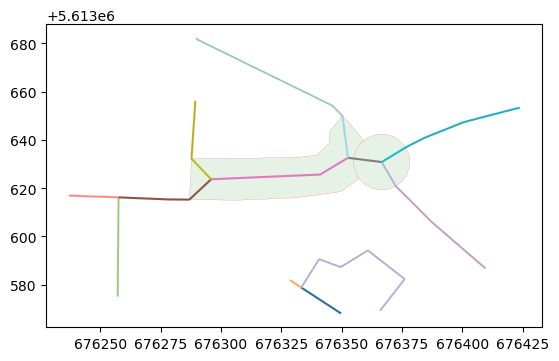

624


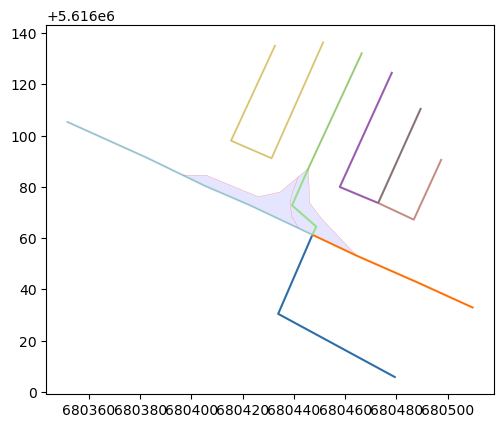

631


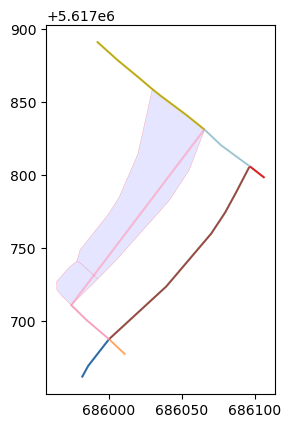

632


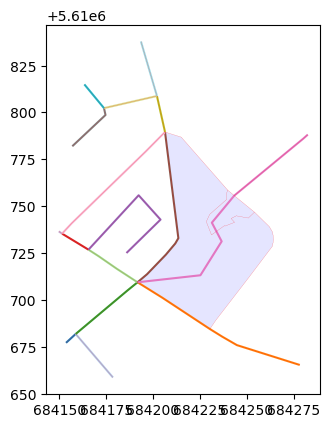

635


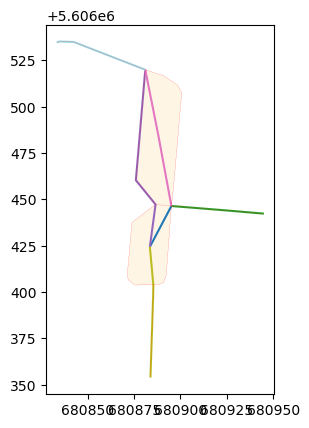

640


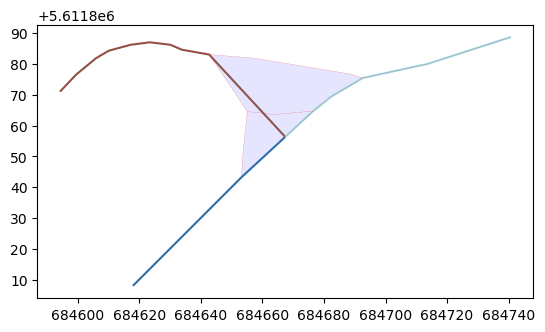

641


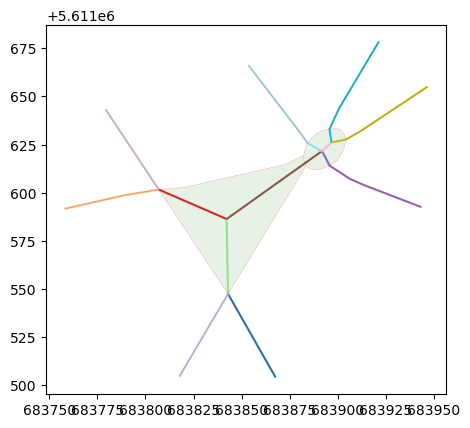

645


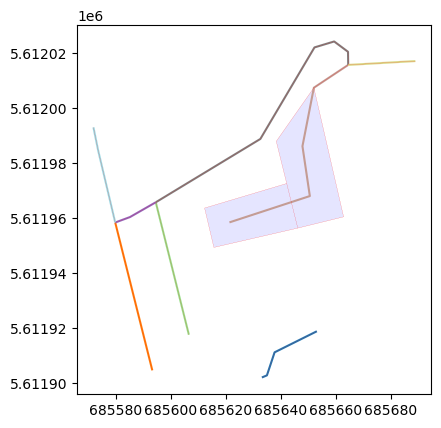

656


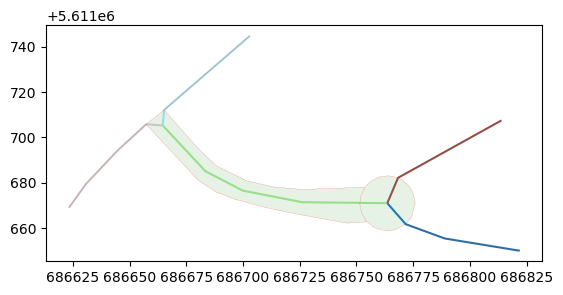

665


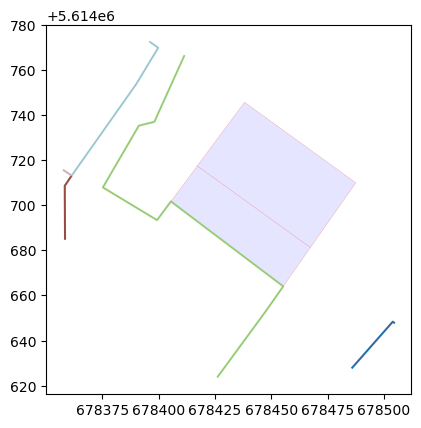

670


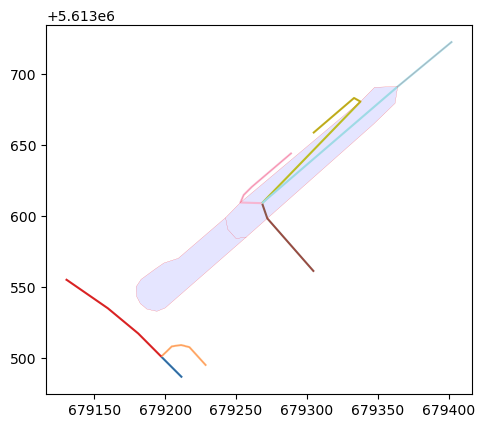

678


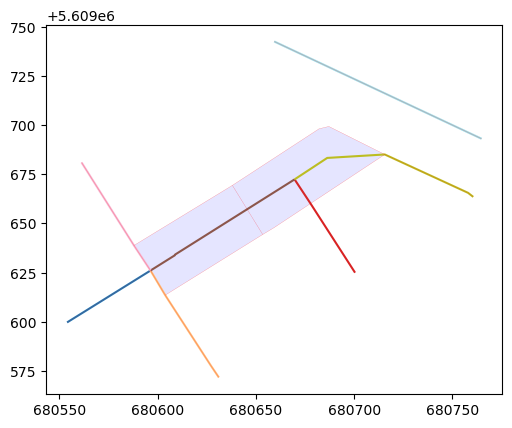

683


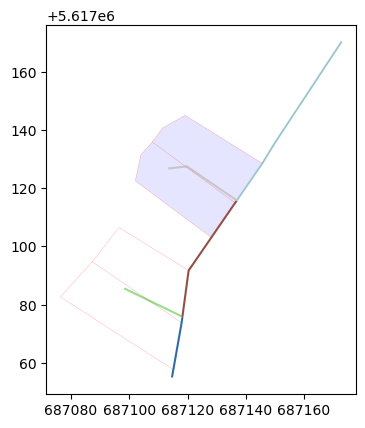

687


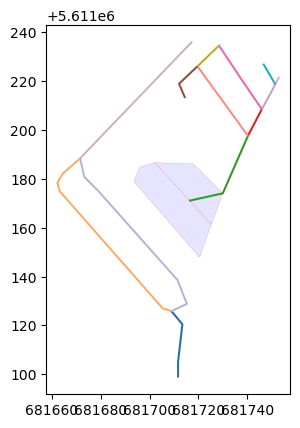

689


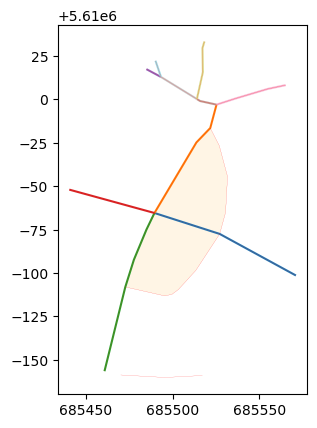

698


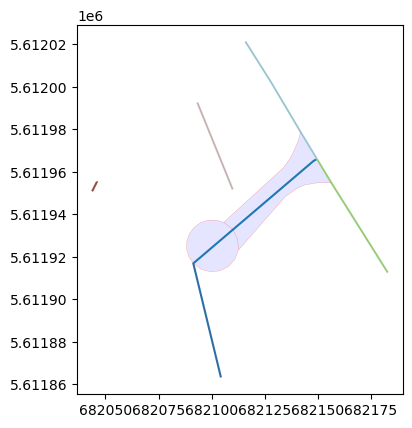

706


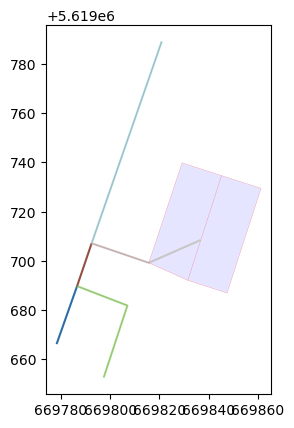

713


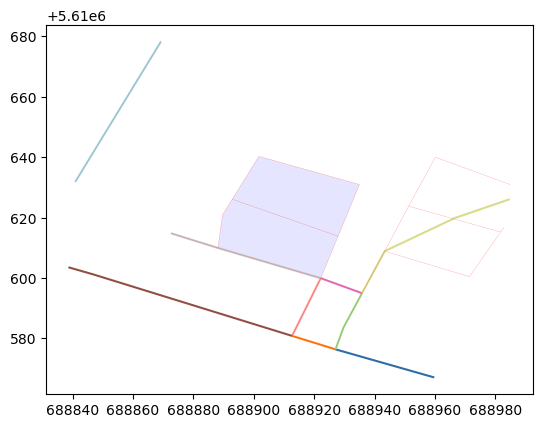

718


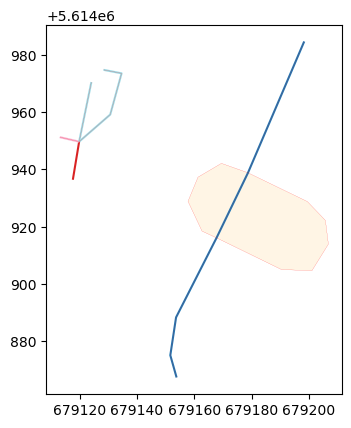

719


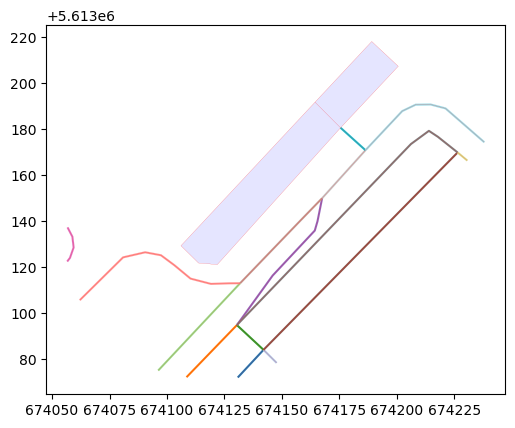

738


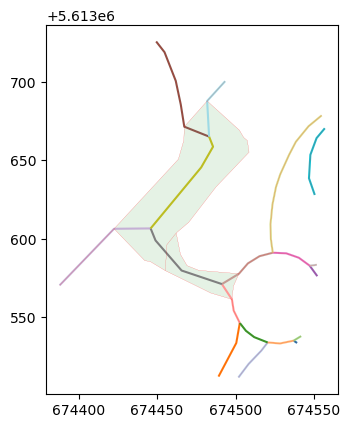

742


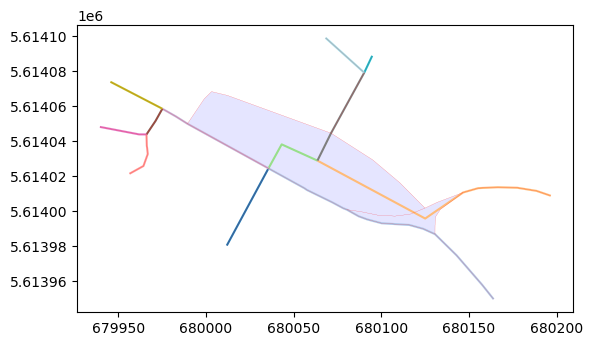

748


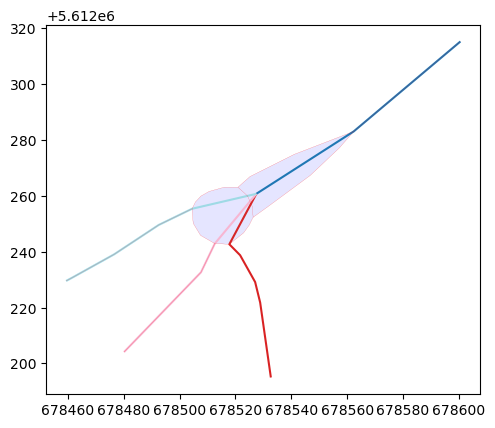

755


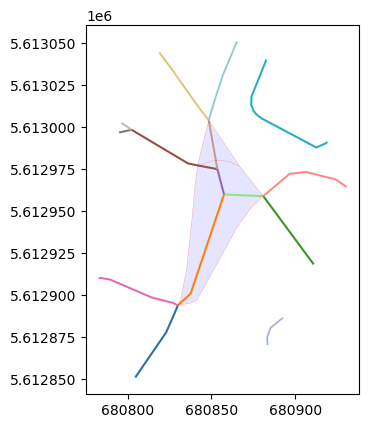

768


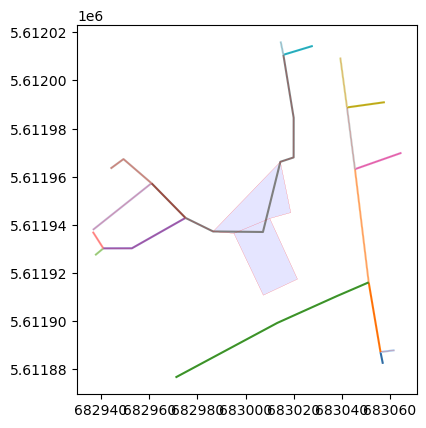

773


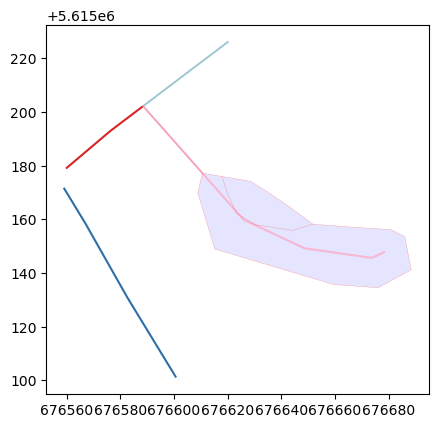

797


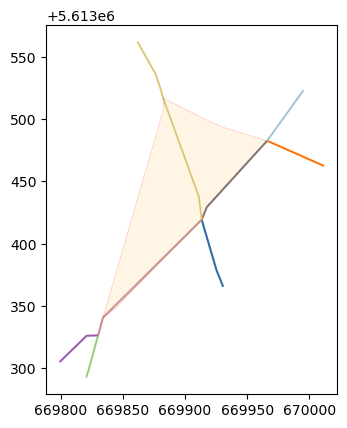

815


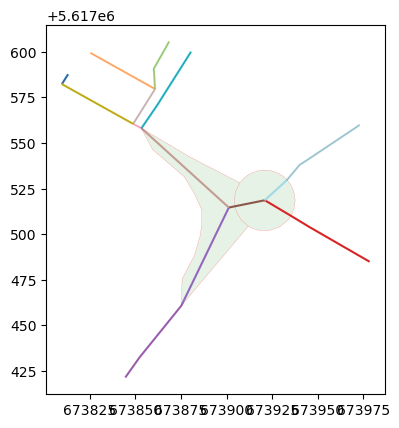

835


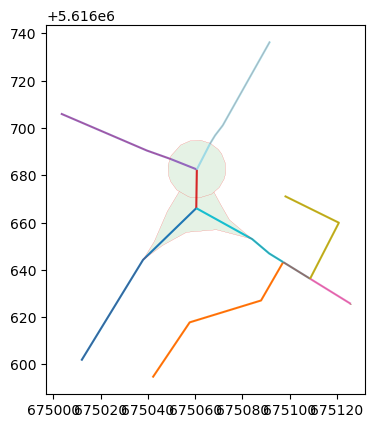

858


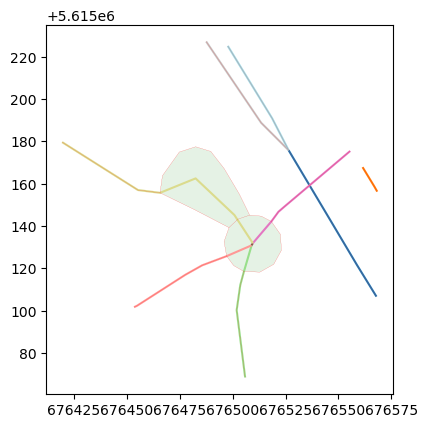

871


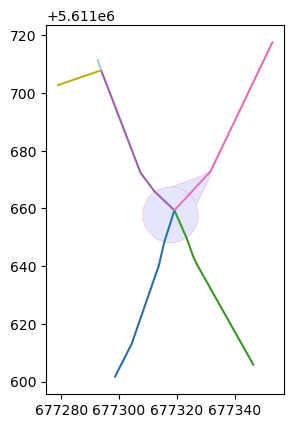

882


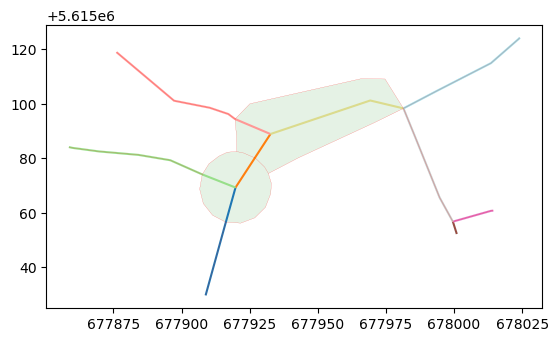

885


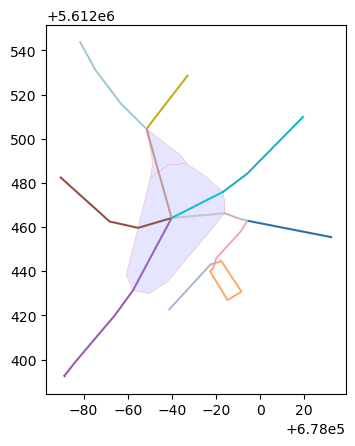

901


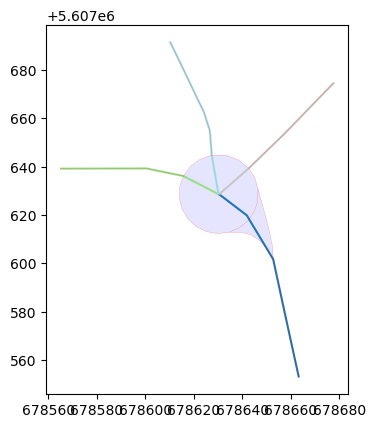

907


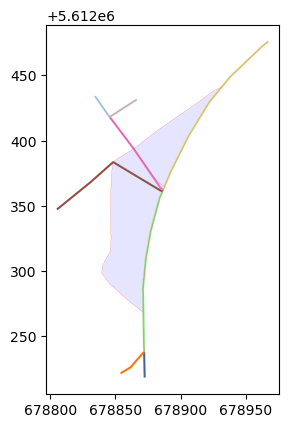

926


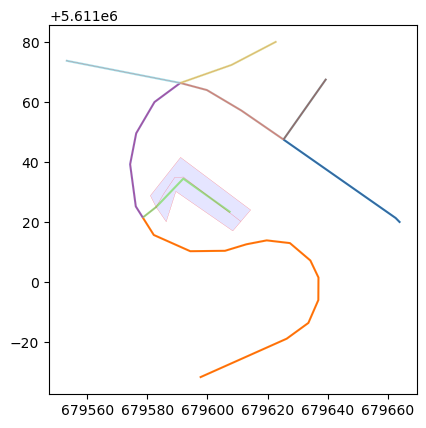

930


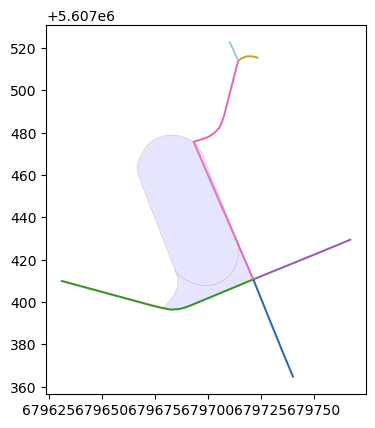

947


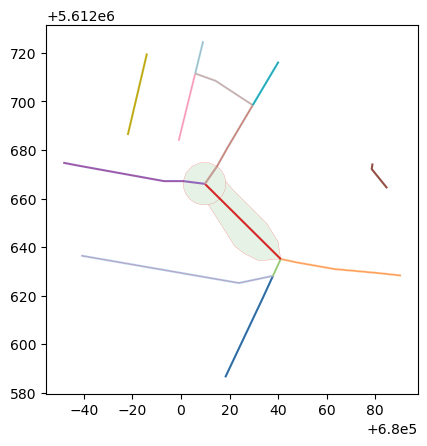

950


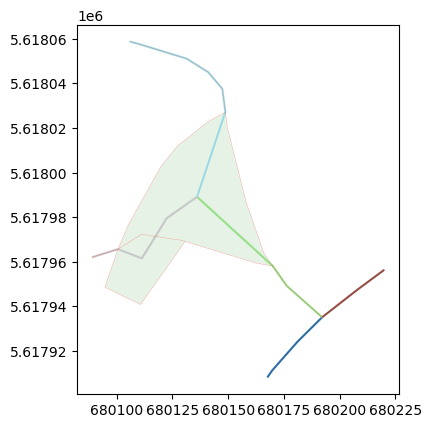

954


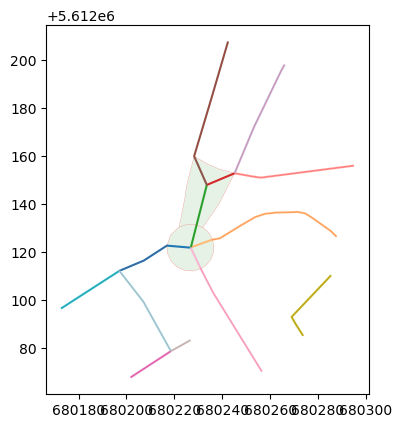

964


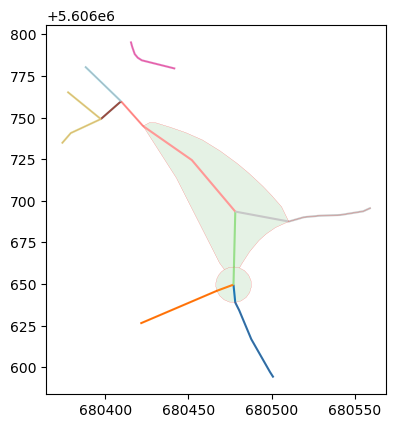

991


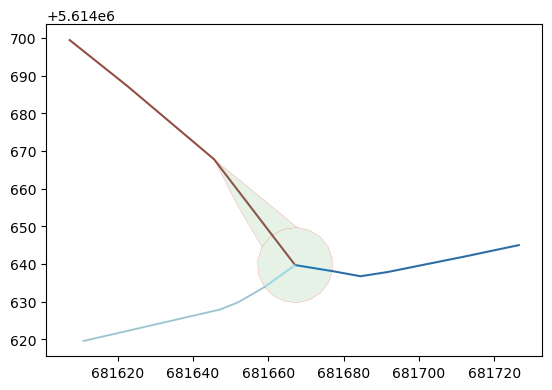

1001


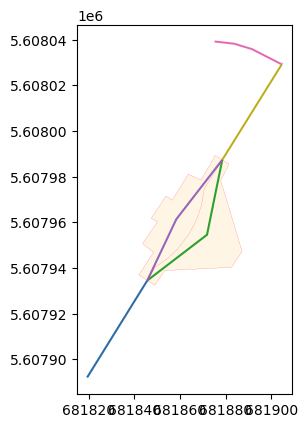

1008


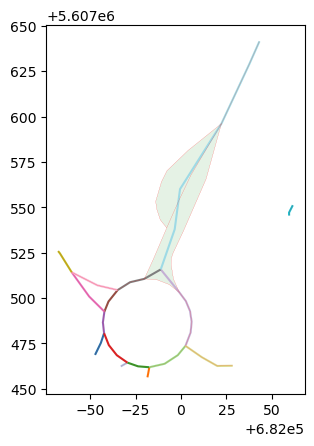

1023


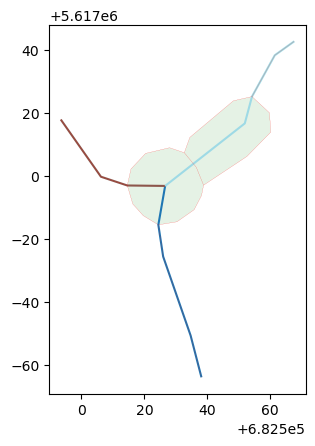

1058


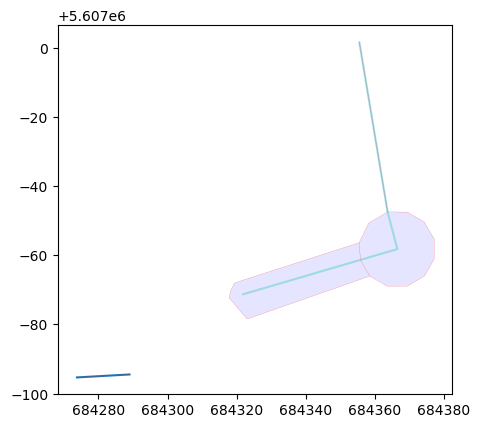

1120


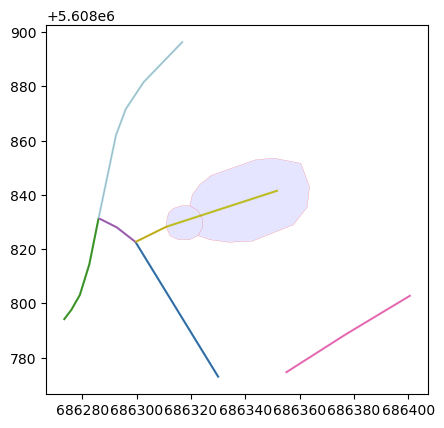

1141


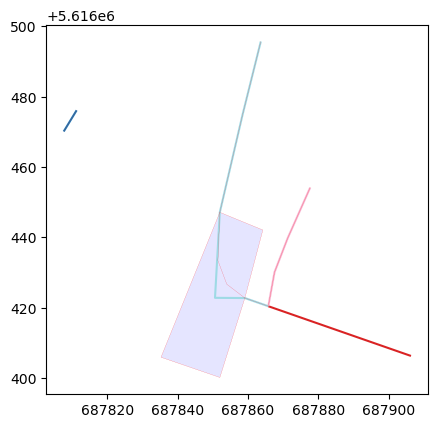

1149


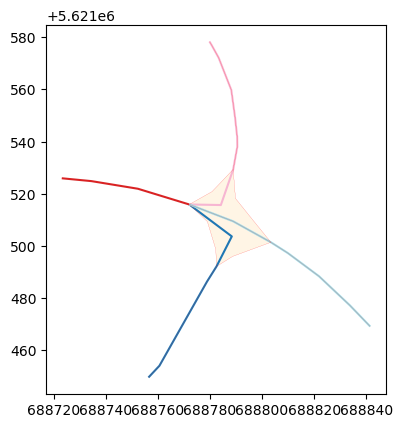

1161


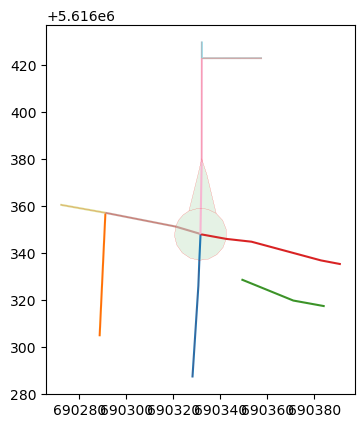

In [19]:
colors = {"iterate": "orange", "skeleton": "green", "drop_interline": "blue"}

for artifact in data_sample.drop_duplicates("comp").itertuples():
    print(artifact.comp)

    # plot the results for visual verification
    geom = artifacts[artifacts.comp == artifact.comp]
    ax = new_roads.clip(geom.buffer(50)).plot(zorder=2, cmap="tab20")
    geom.plot(
        ax=ax,
        alpha=0.1,
    )
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=ax,
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()